# __TASK 4__

In [1]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = np.array([49,58,75,110,112,132,151,276,281,362])

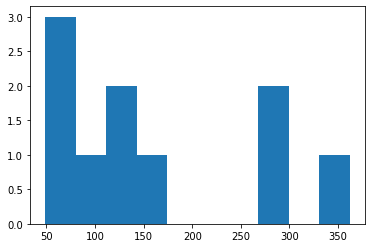

In [3]:
pylab.hist(data)
pylab.show()

In [4]:
print('95%% confidence interval for the mean time: [%f, %f]' % zconfint(data))

95% confidence interval for the mean time: [93.808829, 227.391171]


In [5]:
print("M: %d, p-value: %f" % sign_test(data, 200))

M: -2, p-value: 0.343750


In [6]:
stats.wilcoxon(data - 200)

WilcoxonResult(statistic=17.0, pvalue=0.322265625)

# __TASK 5__

In [7]:
a = np.array([22,22,15,13,19,19,18,20,21,13,13,15])
b = np.array([17,18,18,15,12,4,14,15,10])

stats.mannwhitneyu(b, a, alternative='less')

MannwhitneyuResult(statistic=27.0, pvalue=0.02900499272087373)

In [8]:
stats.mannwhitneyu(a, b, alternative='greater')

MannwhitneyuResult(statistic=81.0, pvalue=0.02900499272087373)

# __TASK 6__

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [10]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
data = pd.read_csv('challenger.txt', sep='\t')

In [12]:
data.head()

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [13]:
a = data[data['Incident']==0]['Temperature'].values
b = data[data['Incident']==1]['Temperature'].values

In [14]:
len(a) + len(b) == data.shape[0]

True

In [22]:
np.random.seed(0)

a_scores = list(map(np.mean, get_bootstrap_samples(a, 1000)))
b_scores = list(map(np.mean, get_bootstrap_samples(b, 1000)))

In [26]:
a_scores = np.array(a_scores)
b_scores = np.array(b_scores)

In [27]:
print("95% confidence interval for the difference between medians",  stat_intervals(a_scores - b_scores, 0.05))

95% confidence interval for the difference between medians [1.42299107 7.93861607]


In [28]:
print("95% confidence interval for the difference between medians",  stat_intervals(b_scores - a_scores, 0.05))

95% confidence interval for the difference between medians [-7.93861607 -1.42299107]


# __TASK 7__

In [29]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [30]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [31]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [32]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [33]:
np.random.seed(0)

In [34]:
print("p-value: %f" % permutation_test(a, b, max_permutations = 10000))

TypeError: 'range' object does not support item assignment